In [224]:
!pip install requests

In [225]:
print('wat')

wat


# Procedures

## 8.1 Collecting weather data from an API

In [228]:
import requests
def make_request(endpoint, payload=None):
    
    """
    Make a request to a specific endpoint on the weather API
    passing headers and optional payload.
    Parameters:
    - endpoint: The endpoint of the API you want to
    make a GET request to.
    - payload: A dictionary of data to pass along
    with the request.
    Returns:
    Response object.
    """
    return requests.get(
                        f'https://www.ncdc.noaa.gov/cdo-web/api/v2/{endpoint}',
                        headers={
                        'token': 'kFpQndPbFvDzUliJAzmAZfefZdqOiqHh'
                        },
                        params=payload
                        )


In [229]:
import datetime
from IPython import display # for updating the cell dynamically

current = datetime.date(2018, 1, 1)
end = datetime.date(2019, 1, 1)
results = []

response = make_request(
                        'data',
                        {
                        'datasetid' : 'GHCND', # Global Historical Climatology Network - Daily (GHCND) dataset
                        'locationid' : 'CITY:US360019', # NYC
                        'startdate' : current,
                        'enddate' : current,
                        'units' : 'metric',
                        'limit' : 1000 # max allowed
                        }
                        )


while current < end:
    # update the cell with status information
    display.clear_output(wait=True)
    display.display(f'Gathering data for {str(current)}')



    
    
    if response.ok:
        
        # we extend the list instead of appending to avoid getting a nested list
        results.extend(response.json()['results'])
    else:
        print('error')
    
    # update the current date to avoid an infinite loop
    current += datetime.timedelta(days=1)


'Gathering data for 2018-12-31'

In [230]:
import pandas as pd

df = pd.DataFrame(results)
df.head()

,date,datatype,station,attributes,value
0,2018-01-01T00:00:00,PRCP,GHCND:US1CTFR0039,",,N,0800",0.0
1,2018-01-01T00:00:00,PRCP,GHCND:US1NJBG0015,",,N,1050",0.0
2,2018-01-01T00:00:00,SNOW,GHCND:US1NJBG0015,",,N,1050",0.0
3,2018-01-01T00:00:00,PRCP,GHCND:US1NJBG0017,",,N,0920",0.0
4,2018-01-01T00:00:00,SNOW,GHCND:US1NJBG0017,",,N,0920",0.0


In [231]:
df.to_csv('nyc_weather_2018.csv', index=False)

In [232]:
import sqlite3
with sqlite3.connect('weather.db') as connection:
    df.to_sql(
            'weather', connection, index=False, if_exists='replace'
            )

In [233]:
response = make_request(
                        'stations',
                        {
                        'datasetid' : 'GHCND', # Global Historical Climatology Network - Daily (GHCND) dataset
                        'locationid' : 'CITY:US360019', # NYC
                        'limit' : 1000 # max allowed
                        }
                        )

stations = pd.DataFrame(response.json()['results'])[['id', 'name', 'latitude', 'longitude', 'elevation']]
stations.to_csv('weather_stations.csv', index=False)

with sqlite3.connect('weather.db') as connection:
    stations.to_sql(
                    'stations', connection, index=False, if_exists='replace'
                    )

## 8.2 Querying and Merging

## Querying

In [236]:
# Setup
import pandas as pd
weather = pd.read_csv('nyc_weather_2018.csv')
weather.head()


,date,datatype,station,attributes,value
0,2018-01-01T00:00:00,PRCP,GHCND:US1CTFR0039,",,N,0800",0.0
1,2018-01-01T00:00:00,PRCP,GHCND:US1NJBG0015,",,N,1050",0.0
2,2018-01-01T00:00:00,SNOW,GHCND:US1NJBG0015,",,N,1050",0.0
3,2018-01-01T00:00:00,PRCP,GHCND:US1NJBG0017,",,N,0920",0.0
4,2018-01-01T00:00:00,SNOW,GHCND:US1NJBG0017,",,N,0920",0.0


In [237]:
snow_data = weather.query('datatype == "SNOW" and value > 0')      # alternative way to filter
snow_data.head()

,date,datatype,station,attributes,value
127,2018-01-01T00:00:00,SNOW,GHCND:US1NYWC0019,",,N,1700",25.0
396,2018-01-01T00:00:00,SNOW,GHCND:US1NYWC0019,",,N,1700",25.0
665,2018-01-01T00:00:00,SNOW,GHCND:US1NYWC0019,",,N,1700",25.0
934,2018-01-01T00:00:00,SNOW,GHCND:US1NYWC0019,",,N,1700",25.0
1203,2018-01-01T00:00:00,SNOW,GHCND:US1NYWC0019,",,N,1700",25.0


Using sql commands to do querying

In [239]:
import sqlite3
with sqlite3.connect('weather.db') as connection:
    snow_data_from_db = pd.read_sql(
                                    'SELECT * FROM weather WHERE datatype == "SNOW" AND value > 0',
                                    connection
                                    )
    
snow_data.reset_index().drop(columns='index').equals(snow_data_from_db)

True

In [240]:
# check if all rows with the SNOW value have a greater than 0 value
weather[(weather.datatype == 'SNOW') & (weather.value > 0)].equals(snow_data)


True

## Merging

In [242]:
# extracting
station_info = pd.read_csv('weather_stations.csv')
station_info.head()

,id,name,latitude,longitude,elevation
0,GHCND:US1CTFR0022,"STAMFORD 2.6 SSW, CT US",41.064100,-73.577000,36.6
1,GHCND:US1CTFR0039,"STAMFORD 4.2 S, CT US",41.037788,-73.568176,6.4
2,GHCND:US1NJBG0001,"BERGENFIELD 0.3 SW, NJ US",40.921298,-74.001983,20.1
3,GHCND:US1NJBG0002,"SADDLE BROOK TWP 0.6 E, NJ US",40.902694,-74.083358,16.8
4,GHCND:US1NJBG0003,"TENAFLY 1.3 W, NJ US",40.914670,-73.977500,21.6


In [243]:
weather.head()

,date,datatype,station,attributes,value
0,2018-01-01T00:00:00,PRCP,GHCND:US1CTFR0039,",,N,0800",0.0
1,2018-01-01T00:00:00,PRCP,GHCND:US1NJBG0015,",,N,1050",0.0
2,2018-01-01T00:00:00,SNOW,GHCND:US1NJBG0015,",,N,1050",0.0
3,2018-01-01T00:00:00,PRCP,GHCND:US1NJBG0017,",,N,0920",0.0
4,2018-01-01T00:00:00,SNOW,GHCND:US1NJBG0017,",,N,0920",0.0


In [244]:
station_info.id.describe()             

count                   330
unique                  330
top       GHCND:US1CTFR0022
freq                      1
Name: id, dtype: object

In [245]:
weather.station.describe()

count                 98185
unique                   73
top       GHCND:USW00094789
freq                   6570
Name: station, dtype: object

In [246]:
station_info.shape[0], weather.shape[0]

(330, 98185)

In [247]:
# function to count rows
def get_row_count(*dfs):
    return [df.shape[0] for df in dfs]
get_row_count(station_info, weather)

[330, 98185]

In [248]:
# for checkiung the shape of a dataframe
def get_info(attr, *dfs):
    return list(map(lambda x: getattr(x, attr), dfs))
get_info('shape', station_info, weather)

[(330, 5), (98185, 5)]

In [249]:
#the intersection of both left and right dataFrame

inner_join = weather.merge(station_info, left_on='station', right_on='id') 
inner_join.sample(5, random_state=0)


,date,datatype,station,attributes,value,id,name,latitude,longitude,elevation
41068,2018-01-01T00:00:00,ADPT,GHCND:USW00014734,",,W,",-194.0,GHCND:USW00014734,"NEWARK LIBERTY INTERNATIONAL AIRPORT, NJ US",40.682750,-74.169270,1.9
7886,2018-01-01T00:00:00,PRCP,GHCND:US1NYNS0007,",,N,0700",0.0,GHCND:US1NYNS0007,"FLORAL PARK 0.4 W, NY US",40.723000,-73.710999,24.1
89184,2018-01-01T00:00:00,TOBS,GHCND:USC00283704,",,7,0700",-15.0,GHCND:USC00283704,"HARRISON, NJ US",40.748100,-74.152000,7.3
49053,2018-01-01T00:00:00,SNOW,GHCND:US1NYNS0035,",,N,1700",0.0,GHCND:US1NYNS0035,"VALLEY STREAM 0.6 SE, NY US",40.657136,-73.697830,3.7
68870,2018-01-01T00:00:00,PRCP,GHCND:US1NJBG0018,",,N,0900",0.0,GHCND:US1NJBG0018,"PALISADES PARK 0.2 WNW, NJ US",40.848094,-74.000247,21.3


In [250]:

weather.merge(station_info.rename(dict(id='station'), axis=1), on='station').sample(5, random_state=0)

,date,datatype,station,attributes,value,name,latitude,longitude,elevation
41068,2018-01-01T00:00:00,ADPT,GHCND:USW00014734,",,W,",-194.0,"NEWARK LIBERTY INTERNATIONAL AIRPORT, NJ US",40.682750,-74.169270,1.9
7886,2018-01-01T00:00:00,PRCP,GHCND:US1NYNS0007,",,N,0700",0.0,"FLORAL PARK 0.4 W, NY US",40.723000,-73.710999,24.1
89184,2018-01-01T00:00:00,TOBS,GHCND:USC00283704,",,7,0700",-15.0,"HARRISON, NJ US",40.748100,-74.152000,7.3
49053,2018-01-01T00:00:00,SNOW,GHCND:US1NYNS0035,",,N,1700",0.0,"VALLEY STREAM 0.6 SE, NY US",40.657136,-73.697830,3.7
68870,2018-01-01T00:00:00,PRCP,GHCND:US1NJBG0018,",,N,0900",0.0,"PALISADES PARK 0.2 WNW, NJ US",40.848094,-74.000247,21.3


In [251]:
left_join = station_info.merge(weather, left_on='id', right_on='station', how='left')
right_join = weather.merge(station_info, left_on='station', right_on='id', how='right')
right_join.tail()


,date,datatype,station,attributes,value,id,name,latitude,longitude,elevation
98437,2018-01-01T00:00:00,TMIN,GHCND:USW00094789,",,W,2400",-13.8,GHCND:USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",40.63915,-73.7639,2.7
98438,2018-01-01T00:00:00,WDF2,GHCND:USW00094789,",,W,",310.0,GHCND:USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",40.63915,-73.7639,2.7
98439,2018-01-01T00:00:00,WDF5,GHCND:USW00094789,",,W,",310.0,GHCND:USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",40.63915,-73.7639,2.7
98440,2018-01-01T00:00:00,WSF2,GHCND:USW00094789,",,W,",13.0,GHCND:USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",40.63915,-73.7639,2.7
98441,2018-01-01T00:00:00,WSF5,GHCND:USW00094789,",,W,",15.2,GHCND:USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",40.63915,-73.7639,2.7


In [252]:
# check the equality of right and ;eft
left_join.sort_index(axis=1).sort_values(['date', 'station']).reset_index().drop(columns='index').equals(
right_join.sort_index(axis=1).sort_values(['date', 'station']).reset_index().drop(columns='index')
)

True

In [253]:
get_info('shape', inner_join, left_join, right_join)

[(98185, 10), (98442, 10), (98442, 10)]

In [254]:
outer_join = weather.merge(
                            station_info[station_info.name.str.contains('NY')],
                            left_on='station', right_on='id', how='outer', indicator=True
                            )
result = pd.concat([
                    outer_join.sample(4, random_state=0),              #.append does not work so iused concat to merge it together
                    outer_join[outer_join.station.isna()].head(2)
                ])
result

,date,datatype,station,attributes,value,id,name,latitude,longitude,elevation,_merge
10711,2018-01-01T00:00:00,PRCP,GHCND:US1NJMD0066,",,N,0900",0.0,NaN,NaN,NaN,NaN,NaN,left_only
16766,2018-01-01T00:00:00,SNOW,GHCND:US1NJMS0011,",,N,0700",0.0,NaN,NaN,NaN,NaN,NaN,left_only
59544,2018-01-01T00:00:00,ASTP,GHCND:USW00014732,",,W,",10264.0,GHCND:USW00014732,"LAGUARDIA AIRPORT, NY US",40.779450,-73.880270,3.0,both
8036,2018-01-01T00:00:00,SNOW,GHCND:US1NJMD0043,",,N,0700",0.0,NaN,NaN,NaN,NaN,NaN,left_only
7665,NaN,NaN,NaN,NaN,NaN,GHCND:US1NJHD0002,"KEARNY 1.7 NW, NJ US",40.772892,-74.140926,29.0,right_only
7666,NaN,NaN,NaN,NaN,NaN,GHCND:US1NJHD0018,"KEARNY 1.7 NNW, NJ US",40.774342,-74.137109,25.6,right_only


In [255]:
# sql command equivalent
import sqlite3
with sqlite3.connect('weather.db') as connection:
    inner_join_from_db = pd.read_sql(                    
    'SELECT * FROM weather JOIN stations ON weather.station == stations.id',
    connection
    )
inner_join_from_db.shape == inner_join.shape

True

In [256]:
# use the dity_data.csv
dirty_data = pd.read_csv(
'dirty_data.csv', index_col='date'
).drop_duplicates().drop(columns='SNWD')
dirty_data.head()

,station,PRCP,SNOW,TMAX,TMIN,TOBS,WESF,inclement_weather
date,,,,,,,,
2018-01-01T00:00:00,?,0.0,0.0,5505.0,-40.0,NaN,NaN,NaN
2018-01-02T00:00:00,GHCND:USC00280907,0.0,0.0,-8.3,-16.1,-12.2,NaN,False
2018-01-03T00:00:00,GHCND:USC00280907,0.0,0.0,-4.4,-13.9,-13.3,NaN,False
2018-01-04T00:00:00,?,20.6,229.0,5505.0,-40.0,NaN,19.3,True
2018-01-05T00:00:00,?,0.3,NaN,5505.0,-40.0,NaN,NaN,NaN


In [257]:
# dropping unncecesary data using the query method
valid_station = dirty_data.query('station != "?"').copy().drop(columns=['WESF', 'station'])
station_with_wesf = dirty_data.query('station == "?"').copy().drop(columns=['station', 'TOBS', 'TMIN', 'TMAX'])

In [258]:
#merging the two columns by the index
valid_station.merge(
                    station_with_wesf, left_index=True, right_index=True
                    ).query('WESF > 0').head()

,PRCP_x,SNOW_x,TMAX,TMIN,TOBS,inclement_weather_x,PRCP_y,SNOW_y,WESF,inclement_weather_y
date,,,,,,,,,,
2018-01-30T00:00:00,0.0,0.0,6.7,-1.7,-0.6,False,1.5,13.0,1.8,True
2018-03-08T00:00:00,48.8,NaN,1.1,-0.6,1.1,False,28.4,NaN,28.7,NaN
2018-03-13T00:00:00,4.1,51.0,5.6,-3.9,0.0,True,3.0,13.0,3.0,True
2018-03-21T00:00:00,0.0,0.0,2.8,-2.8,0.6,False,6.6,114.0,8.6,True
2018-04-02T00:00:00,9.1,127.0,12.8,-1.1,-1.1,True,14.0,152.0,15.2,True


In [259]:
# renames the suffixes
valid_station.merge(
station_with_wesf, left_index=True, right_index=True, suffixes=('', '_?')
).query('WESF > 0').head()

,PRCP,SNOW,TMAX,TMIN,TOBS,inclement_weather,PRCP_?,SNOW_?,WESF,inclement_weather_?
date,,,,,,,,,,
2018-01-30T00:00:00,0.0,0.0,6.7,-1.7,-0.6,False,1.5,13.0,1.8,True
2018-03-08T00:00:00,48.8,NaN,1.1,-0.6,1.1,False,28.4,NaN,28.7,NaN
2018-03-13T00:00:00,4.1,51.0,5.6,-3.9,0.0,True,3.0,13.0,3.0,True
2018-03-21T00:00:00,0.0,0.0,2.8,-2.8,0.6,False,6.6,114.0,8.6,True
2018-04-02T00:00:00,9.1,127.0,12.8,-1.1,-1.1,True,14.0,152.0,15.2,True


In [260]:
#merging using the join method
valid_station.join(station_with_wesf, rsuffix='_?').query('WESF > 0').head()

,PRCP,SNOW,TMAX,TMIN,TOBS,inclement_weather,PRCP_?,SNOW_?,WESF,inclement_weather_?
date,,,,,,,,,,
2018-01-30T00:00:00,0.0,0.0,6.7,-1.7,-0.6,False,1.5,13.0,1.8,True
2018-03-08T00:00:00,48.8,NaN,1.1,-0.6,1.1,False,28.4,NaN,28.7,NaN
2018-03-13T00:00:00,4.1,51.0,5.6,-3.9,0.0,True,3.0,13.0,3.0,True
2018-03-21T00:00:00,0.0,0.0,2.8,-2.8,0.6,False,6.6,114.0,8.6,True
2018-04-02T00:00:00,9.1,127.0,12.8,-1.1,-1.1,True,14.0,152.0,15.2,True


In [261]:
# set the index of the dataframe weather and station_info into station
weather.set_index('station', inplace=True)
station_info.set_index('id', inplace=True)

In [262]:
# check which index is present in both dataframes
weather.index.intersection(station_info.index)

Index(['GHCND:US1CTFR0039', 'GHCND:US1NJBG0015', 'GHCND:US1NJBG0017',
       'GHCND:US1NJBG0018', 'GHCND:US1NJBG0023', 'GHCND:US1NJBG0030',
       'GHCND:US1NJBG0039', 'GHCND:US1NJBG0044', 'GHCND:US1NJES0018',
       'GHCND:US1NJES0024', 'GHCND:US1NJMD0043', 'GHCND:US1NJMD0045',
       'GHCND:US1NJMD0062', 'GHCND:US1NJMD0066', 'GHCND:US1NJMD0070',
       'GHCND:US1NJMD0073', 'GHCND:US1NJMD0074', 'GHCND:US1NJMN0010',
       'GHCND:US1NJMN0012', 'GHCND:US1NJMN0048', 'GHCND:US1NJMN0069',
       'GHCND:US1NJMN0104', 'GHCND:US1NJMS0011', 'GHCND:US1NJMS0040',
       'GHCND:US1NJMS0049', 'GHCND:US1NJMS0059', 'GHCND:US1NJMS0089',
       'GHCND:US1NJPS0005', 'GHCND:US1NJPS0012', 'GHCND:US1NJPS0014',
       'GHCND:US1NJPS0022', 'GHCND:US1NJPS0025', 'GHCND:US1NJUN0003',
       'GHCND:US1NJUN0010', 'GHCND:US1NJUN0014', 'GHCND:US1NJUN0017',
       'GHCND:US1NYKN0025', 'GHCND:US1NYNS0007', 'GHCND:US1NYNS0014',
       'GHCND:US1NYNS0024', 'GHCND:US1NYNS0027', 'GHCND:US1NYNS0030',
       'GHCND:US1NYN

In [263]:
# this tells us what is left in the weather table compared to the station_info
weather.index.difference(station_info.index)

Index([], dtype='object')

In [264]:
# this tells us what is left in the station_info compared to the weather
station_info.index.difference(weather.index)

Index(['GHCND:US1CTFR0022', 'GHCND:US1NJBG0001', 'GHCND:US1NJBG0002',
       'GHCND:US1NJBG0003', 'GHCND:US1NJBG0005', 'GHCND:US1NJBG0006',
       'GHCND:US1NJBG0008', 'GHCND:US1NJBG0010', 'GHCND:US1NJBG0011',
       'GHCND:US1NJBG0012',
       ...
       'GHCND:USC00308749', 'GHCND:USC00308946', 'GHCND:USC00309117',
       'GHCND:USC00309270', 'GHCND:USC00309400', 'GHCND:USC00309466',
       'GHCND:USC00309576', 'GHCND:USC00309580', 'GHCND:USW00014708',
       'GHCND:USW00014786'],
      dtype='object', length=257)

In [265]:
# set difference in both directions
ny_in_name = station_info[station_info.name.str.contains('NY')]
ny_in_name.index.difference(weather.index).shape[0]\
+ weather.index.difference(ny_in_name.index).shape[0]\
== weather.index.symmetric_difference(ny_in_name.index).shape[0]

True

In [266]:
# checks the intersection of both dataframes
weather.index.unique().union(station_info.index)

Index(['GHCND:US1CTFR0022', 'GHCND:US1CTFR0039', 'GHCND:US1NJBG0001',
       'GHCND:US1NJBG0002', 'GHCND:US1NJBG0003', 'GHCND:US1NJBG0005',
       'GHCND:US1NJBG0006', 'GHCND:US1NJBG0008', 'GHCND:US1NJBG0010',
       'GHCND:US1NJBG0011',
       ...
       'GHCND:USW00014708', 'GHCND:USW00014732', 'GHCND:USW00014734',
       'GHCND:USW00014786', 'GHCND:USW00054743', 'GHCND:USW00054787',
       'GHCND:USW00094728', 'GHCND:USW00094741', 'GHCND:USW00094745',
       'GHCND:USW00094789'],
      dtype='object', length=330)

## 8.3 Dataframe Operations

In [268]:
# setup
import numpy as np
import pandas as pd
weather = pd.read_csv('nyc_weather_2018.csv', parse_dates=['date'])
weather.head()


,date,datatype,station,attributes,value
0,2018-01-01,PRCP,GHCND:US1CTFR0039,",,N,0800",0.0
1,2018-01-01,PRCP,GHCND:US1NJBG0015,",,N,1050",0.0
2,2018-01-01,SNOW,GHCND:US1NJBG0015,",,N,1050",0.0
3,2018-01-01,PRCP,GHCND:US1NJBG0017,",,N,0920",0.0
4,2018-01-01,SNOW,GHCND:US1NJBG0017,",,N,0920",0.0


In [269]:
fb = pd.read_csv('fb_2018.csv', index_col='date', parse_dates=True)
fb.head()

,open,high,low,close,volume
date,,,,,
2018-01-02,177.68,181.58,177.5500,181.42,18151903
2018-01-03,181.88,184.78,181.3300,184.67,16886563
2018-01-04,184.90,186.21,184.0996,184.33,13880896
2018-01-05,185.59,186.90,184.9300,186.85,13574535
2018-01-08,187.20,188.90,186.3300,188.28,17994726


In [270]:
# the z-scores for the volume traded and look at the days where this was more than 3 standard deviations
# from the mean
fb.assign(
        abs_z_score_volume=lambda x: x.volume.sub(x.volume.mean()).div(x.volume.std()).abs()
        ).query('abs_z_score_volume > 3')


,open,high,low,close,volume,abs_z_score_volume
date,,,,,,
2018-03-19,177.01,177.17,170.06,172.56,88140060,3.145078
2018-03-20,167.47,170.20,161.95,168.15,129851768,5.315169
2018-03-21,164.80,173.40,163.30,169.39,106598834,4.105413
2018-03-26,160.82,161.10,149.02,160.06,126116634,5.120845
2018-07-26,174.89,180.13,173.75,176.26,169803668,7.393705


In [271]:
# use rank and pct_change method to see which day has the highest volume
fb.assign(
        volume_pct_change=fb.volume.pct_change(),
        pct_change_rank=lambda x: x.volume_pct_change.abs().rank(
        ascending=False
        )
        ).nsmallest(5, 'pct_change_rank')

,open,high,low,close,volume,volume_pct_change,pct_change_rank
date,,,,,,,
2018-01-12,178.06,181.48,177.40,179.37,77551299,7.087876,1.0
2018-03-19,177.01,177.17,170.06,172.56,88140060,2.611789,2.0
2018-07-26,174.89,180.13,173.75,176.26,169803668,1.628841,3.0
2018-09-21,166.64,167.25,162.81,162.93,45994800,1.428956,4.0
2018-03-26,160.82,161.10,149.02,160.06,126116634,1.352496,5.0


## Binning and thresholds

In [273]:
(fb.volume.value_counts() > 1).sum()

0

In [274]:
# we can use the pd.cut method to create bins or partitions
volume_binned = pd.cut(fb.volume, bins=3, labels=['low', 'med', 'high']) # divide iunto 3 equal parts or bins the volume column value
volume_binned.value_counts()


volume
low     240
med       8
high      3
Name: count, dtype: int64

In [275]:
fb[volume_binned == 'high'].sort_values(
                                        'volume', ascending=False
                                        )

,open,high,low,close,volume
date,,,,,
2018-07-26,174.89,180.13,173.75,176.26,169803668
2018-03-20,167.47,170.20,161.95,168.15,129851768
2018-03-26,160.82,161.10,149.02,160.06,126116634


In [276]:
# July 25th Facebook announced disappointing user growth and the stock tanked in the after hours:
fb['2018-07-25':'2018-07-26'] # 

,open,high,low,close,volume
date,,,,,
2018-07-25,215.715,218.62,214.27,217.50,64592585
2018-07-26,174.890,180.13,173.75,176.26,169803668


In [277]:
# Cambridge Analytica scandal broke on Saturday March 17th, so we look to the Monday for the numbers:
fb['2018-03-16':'2018-03-20']

,open,high,low,close,volume
date,,,,,
2018-03-16,184.49,185.33,183.41,185.09,24403438
2018-03-19,177.01,177.17,170.06,172.56,88140060
2018-03-20,167.47,170.20,161.95,168.15,129851768


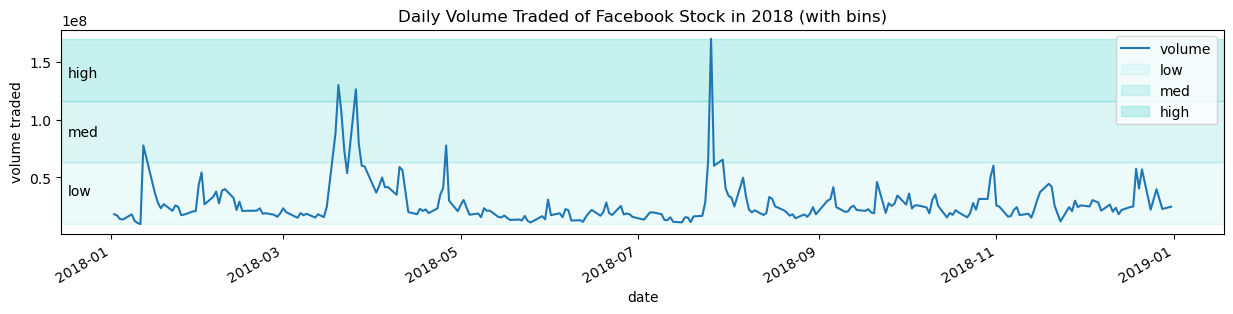

In [278]:
import matplotlib.pyplot as plt
# plot using line plot with bins of the volume

fb.plot(y='volume', figsize=(15, 3), title='Daily Volume Traded of Facebook Stock in 2018 (with bins)')
for bin_name, alpha, bounds in zip(
                                ['low', 'med', 'high'], [0.1, 0.2, 0.3], pd.cut(fb.volume, bins=3).unique().categories.values
                                ):
                                plt.axhspan(bounds.left, bounds.right, alpha=alpha, label=bin_name, color='mediumturquoise')
                                plt.annotate(bin_name, xy=('2017-12-17', (bounds.left + bounds.right)/2.1))
plt.ylabel('volume traded')
plt.legend()
plt.show()

In [279]:
# using quantiles
volume_qbinned = pd.qcut(fb.volume, q=4, labels=['q1', 'q2', 'q3', 'q4'])
volume_qbinned.value_counts()

volume
q1    63
q2    63
q4    63
q3    62
Name: count, dtype: int64

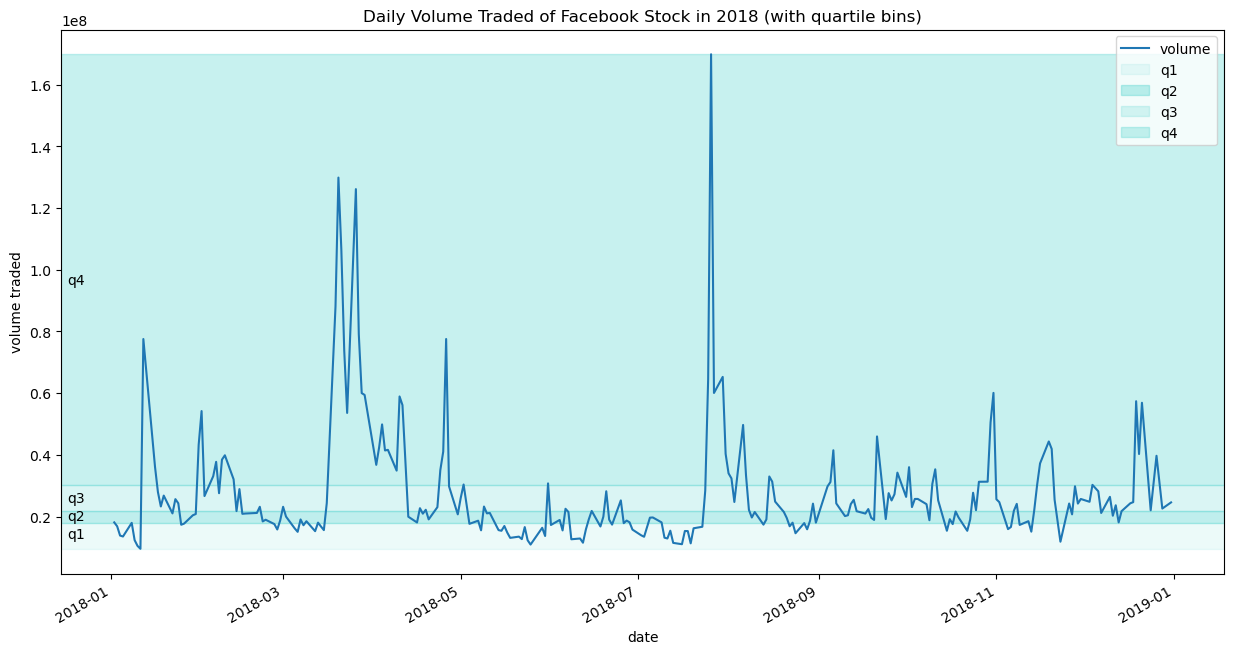

In [280]:
# using quantiles instead or 3 bins

fb.plot(y='volume', figsize=(15, 8), title='Daily Volume Traded of Facebook Stock in 2018 (with quartile bins)')
for bin_name, alpha, bounds in zip(
                                ['q1', 'q2', 'q3', 'q4'], [0.1, 0.35, 0.2, 0.3], pd.qcut(fb.volume, q=4).unique().categories.values
                                ):
                                plt.axhspan(bounds.left, bounds.right, alpha=alpha, label=bin_name, color='mediumturquoise')
                                plt.annotate(bin_name, xy=('2017-12-17', (bounds.left + bounds.right)/2.1))
    
plt.ylabel('volume traded')
plt.legend()
plt.show()


In [285]:
weather

,id,name,latitude,longitude,elevation
0,GHCND:US1CTFR0022,"STAMFORD 2.6 SSW, CT US",41.064100,-73.577000,36.6
1,GHCND:US1CTFR0039,"STAMFORD 4.2 S, CT US",41.037788,-73.568176,6.4
2,GHCND:US1NJBG0001,"BERGENFIELD 0.3 SW, NJ US",40.921298,-74.001983,20.1
3,GHCND:US1NJBG0002,"SADDLE BROOK TWP 0.6 E, NJ US",40.902694,-74.083358,16.8
4,GHCND:US1NJBG0003,"TENAFLY 1.3 W, NJ US",40.914670,-73.977500,21.6
...,...,...,...,...,...
325,GHCND:USW00054787,"FARMINGDALE REPUBLIC AIRPORT, NY US",40.734430,-73.416370,22.8
326,GHCND:USW00094728,"NY CITY CENTRAL PARK, NY US",40.778980,-73.969250,42.7
327,GHCND:USW00094741,"TETERBORO AIRPORT, NJ US",40.858980,-74.056160,0.8
328,GHCND:USW00094745,"WESTCHESTER CO AIRPORT, NY US",41.062360,-73.704540,112.9


In [293]:
# pivot the weather dataframe
central_park_weather = inner_join.query(
                                    'station == "GHCND:USW00094728"'
                                    ).pivot_table(index='date', columns='datatype', values='value')

In [295]:
central_park_weather

datatype,ADPT,ASLP,ASTP,AWBT,AWND,PRCP,RHAV,RHMN,RHMX,SNOW,SNWD,TMAX,TMIN,WDF2,WDF5,WSF2,WSF5
date,,,,,,,,,,,,,,,,,
2018-01-01T00:00:00,-194.0,10278.0,10224.0,-122.0,3.5,0.0,48.0,34.0,60.0,0.0,0.0,-7.1,-13.8,300.0,300.0,6.7,11.2


In [297]:
central_park_weather.SNOW.clip(0, 1).value_counts()

SNOW
0.0    1
Name: count, dtype: int64

## Applying function

In [318]:
import numpy as np
fb.apply(
lambda x: np.vectorize(lambda y: len(str(np.ceil(y))))(x)
).astype('int64').equals(
fb.map(lambda x: len(str(np.ceil(x))))
)

True

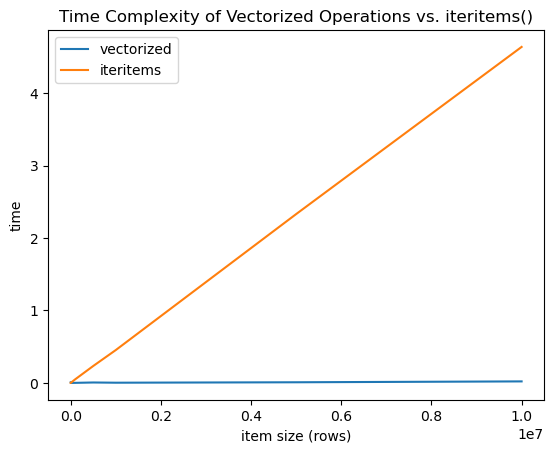

In [316]:
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

np.random.seed(0)
vectorized_results = {}
iteritems_results = {}

for size in [10, 100, 1000, 10000, 100000, 500000, 1000000, 5000000, 10000000]:
    test = pd.Series(np.random.uniform(size=size))
    
    start = time.time()
    x = test + 10
    end = time.time()
    vectorized_results[size] = end - start
    
    start = time.time()
    x = []
    
    for i, v in test.items():
        x.append(v + 10)
    x = pd.Series(x)
    end = time.time()
    iteritems_results[size] = end - start

pd.DataFrame(
            [pd.Series(vectorized_results, name='vectorized'), pd.Series(iteritems_results, name='iteritems')]
            ).T.plot(title='Time Complexity of Vectorized Operations vs. iteritems()')

plt.xlabel('item size (rows)')
plt.ylabel('time')

plt.show()

## Pipes

In [331]:
def get_info(df):
    return '%d rows and %d columns and max closing z-score was %d' % (*df.shape, df.close.max())
    
fb.loc['2018-Q1'].apply(lambda x: (x - x.mean())/x.std()).pipe(get_info)\
== get_info(fb.loc['2018-Q1'].apply(lambda x: (x - x.mean())/x.std()))

True

In [333]:
fb.pipe(pd.DataFrame.rolling, '20D').mean().equals(fb.rolling('20D').mean())

True

In [335]:
pd.DataFrame.rolling(fb, '20D').mean().equals(fb.rolling('20D').mean())

True

## 8.4 Aggregations

In [347]:
import numpy as np
import pandas as pd

weather = pd.read_csv('weather_by_station.csv', index_col='date', parse_dates=True)
weather.head()


,datatype,station,value,station_name
date,,,,
2018-01-01,PRCP,GHCND:US1CTFR0039,0.0,"STAMFORD 4.2 S, CT US"
2018-01-01,PRCP,GHCND:US1NJBG0015,0.0,"NORTH ARLINGTON 0.7 WNW, NJ US"
2018-01-01,SNOW,GHCND:US1NJBG0015,0.0,"NORTH ARLINGTON 0.7 WNW, NJ US"
2018-01-01,PRCP,GHCND:US1NJBG0017,0.0,"GLEN ROCK 0.7 SSE, NJ US"
2018-01-01,SNOW,GHCND:US1NJBG0017,0.0,"GLEN ROCK 0.7 SSE, NJ US"


In [351]:
fb = pd.read_csv('fb_2018.csv', index_col='date', parse_dates=True).assign(
trading_volume=lambda x: pd.cut(x.volume, bins=3, labels=['low', 'med', 'high'])
)
fb.head()

,open,high,low,close,volume,trading_volume
date,,,,,,
2018-01-02,177.68,181.58,177.5500,181.42,18151903,low
2018-01-03,181.88,184.78,181.3300,184.67,16886563,low
2018-01-04,184.90,186.21,184.0996,184.33,13880896,low
2018-01-05,185.59,186.90,184.9300,186.85,13574535,low
2018-01-08,187.20,188.90,186.3300,188.28,17994726,low


In [353]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)


## Summarizing DataFrames

In [356]:
fb.agg({
        'open': np.mean,
        'high': np.max,
        'low': np.min,
        'close': np.mean,
        'volume': np.sum
        })

C:\Users\Reuel\AppData\Local\Temp\ipykernel_204\3804002387.py:1: FutureWarning: The provided callable <function mean at 0x0000000000B41620> is currently using Series.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  fb.agg({
C:\Users\Reuel\AppData\Local\Temp\ipykernel_204\3804002387.py:1: FutureWarning: The provided callable <function max at 0x0000000000B40C20> is currently using Series.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  fb.agg({
C:\Users\Reuel\AppData\Local\Temp\ipykernel_204\3804002387.py:1: FutureWarning: The provided callable <function min at 0x0000000000B40D60> is currently using Series.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  fb.agg({
C:\Users\Reuel\AppData\Local\Temp\ipykernel_204\3804002387

open            171.45
high            218.62
low             123.02
close           171.51
volume   6949682394.00
dtype: float64

In [358]:
fb.agg({
'open': 'mean',
'high': ['min', 'max'],
'low': ['min', 'max'],
'close': 'mean'
})

,open,high,low,close
mean,171.45,NaN,NaN,171.51
min,NaN,129.74,123.02,NaN
max,NaN,218.62,214.27,NaN


In [360]:
fb.groupby('trading_volume').mean()

C:\Users\Reuel\AppData\Local\Temp\ipykernel_204\46027550.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fb.groupby('trading_volume').mean()


,open,high,low,close,volume
trading_volume,,,,,
low,171.36,173.46,169.31,171.43,24547207.71
med,175.82,179.42,172.11,175.14,79072559.12
high,167.73,170.48,161.57,168.16,141924023.33


In [362]:
fb.groupby('trading_volume')['close'].agg(['min', 'max', 'mean'])

C:\Users\Reuel\AppData\Local\Temp\ipykernel_204\3607524933.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fb.groupby('trading_volume')['close'].agg(['min', 'max', 'mean'])


,min,max,mean
trading_volume,,,
low,124.06,214.67,171.43
med,152.22,217.50,175.14
high,160.06,176.26,168.16


In [364]:
fb_agg = fb.groupby('trading_volume').agg({
'open': 'mean',
'high': ['min', 'max'],
'low': ['min', 'max'],
'close': 'mean'
})
fb_agg

C:\Users\Reuel\AppData\Local\Temp\ipykernel_204\3817794008.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fb_agg = fb.groupby('trading_volume').agg({


open   high           low         close
                 mean    min    max    min    max   mean
trading_volume                                          
low            171.36 129.74 216.20 123.02 212.60 171.43
med            175.82 162.85 218.62 150.75 214.27 175.14
high           167.73 161.10 180.13 149.02 173.75 168.16

In [366]:
fb_agg.columns

MultiIndex([( 'open', 'mean'),
            ( 'high',  'min'),
            ( 'high',  'max'),
            (  'low',  'min'),
            (  'low',  'max'),
            ('close', 'mean')],
           )

In [368]:
fb_agg.columns = ['_'.join(col_agg) for col_agg in fb_agg.columns]
fb_agg.head()

,open_mean,high_min,high_max,low_min,low_max,close_mean
trading_volume,,,,,,
low,171.36,129.74,216.20,123.02,212.60,171.43
med,175.82,162.85,218.62,150.75,214.27,175.14
high,167.73,161.10,180.13,149.02,173.75,168.16


## Pivot Tables and Crosstabs

In [375]:
fb.pivot_table(columns='trading_volume')

C:\Users\Reuel\AppData\Local\Temp\ipykernel_204\3311801863.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  fb.pivot_table(columns='trading_volume')


trading_volume,low,med,high
close,171.43,175.14,168.16
high,173.46,179.42,170.48
low,169.31,172.11,161.57
open,171.36,175.82,167.73
volume,24547207.71,79072559.12,141924023.33


In [377]:
fb.pivot_table(index='trading_volume')

C:\Users\Reuel\AppData\Local\Temp\ipykernel_204\1557930399.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  fb.pivot_table(index='trading_volume')


,close,high,low,open,volume
trading_volume,,,,,
low,171.43,173.46,169.31,171.36,24547207.71
med,175.14,179.42,172.11,175.82,79072559.12
high,168.16,170.48,161.57,167.73,141924023.33


In [379]:
weather.reset_index().pivot_table(
index=['date', 'station', 'station_name'],
columns='datatype',
values='value',
aggfunc='median'
).reset_index().tail()


datatype,date,station,station_name,AWND,DAPR,MDPR,PGTM,PRCP,SNOW,SNWD,...,WSF5,WT01,WT02,WT03,WT04,WT05,WT06,WT08,WT09,WT11
28740,2018-12-31,GHCND:USW00054787,"FARMINGDALE REPUBLIC AIRPORT, NY US",5.00,NaN,NaN,2052.00,28.70,NaN,NaN,...,15.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28741,2018-12-31,GHCND:USW00094728,"NY CITY CENTRAL PARK, NY US",NaN,NaN,NaN,NaN,25.90,0.00,0.00,...,NaN,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28742,2018-12-31,GHCND:USW00094741,"TETERBORO AIRPORT, NJ US",1.70,NaN,NaN,1954.00,29.20,NaN,NaN,...,8.90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28743,2018-12-31,GHCND:USW00094745,"WESTCHESTER CO AIRPORT, NY US",2.70,NaN,NaN,2212.00,24.40,NaN,NaN,...,11.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28744,2018-12-31,GHCND:USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",4.10,NaN,NaN,NaN,31.20,0.00,0.00,...,12.50,1.00,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [381]:
pd.crosstab(
index=fb.trading_volume,
columns=fb.index.month,
colnames=['month'] # name the columns index
)

month,1,2,3,4,5,6,7,8,9,10,11,12
trading_volume,,,,,,,,,,,,
low,20,19,15,20,22,21,18,23,19,23,21,19
med,1,0,4,1,0,0,2,0,0,0,0,0
high,0,0,2,0,0,0,1,0,0,0,0,0


In [383]:
pd.crosstab(
index=fb.trading_volume,
columns=fb.index.month,
colnames=['month'],
normalize='columns'
)

month,1,2,3,4,5,6,7,8,9,10,11,12
trading_volume,,,,,,,,,,,,
low,0.95,1.00,0.71,0.95,1.00,1.00,0.86,1.00,1.00,1.00,1.00,1.00
med,0.05,0.00,0.19,0.05,0.00,0.00,0.10,0.00,0.00,0.00,0.00,0.00
high,0.00,0.00,0.10,0.00,0.00,0.00,0.05,0.00,0.00,0.00,0.00,0.00


In [385]:
pd.crosstab(
index=fb.trading_volume,
columns=fb.index.month,
colnames=['month'],
values=fb.close,
aggfunc=np.mean
)

C:\Users\Reuel\AppData\Local\Temp\ipykernel_204\532444572.py:1: FutureWarning: The provided callable <function mean at 0x0000000000B41620> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  pd.crosstab(


month,1,2,3,4,5,6,7,8,9,10,11,12
trading_volume,,,,,,,,,,,,
low,185.24,180.27,177.07,163.29,182.93,195.27,201.92,177.49,164.38,154.19,141.64,137.16
med,179.37,NaN,164.76,174.16,NaN,NaN,194.28,NaN,NaN,NaN,NaN,NaN
high,NaN,NaN,164.11,NaN,NaN,NaN,176.26,NaN,NaN,NaN,NaN,NaN


## 8.5 Time Series

In [390]:
import numpy as np
import pandas as pd
fb = pd.read_csv('fb_2018.csv', index_col='date', parse_dates=True).assign(
trading_volume=lambda x: pd.cut(x.volume, bins=3, labels=['low', 'med', 'high'])
)
fb.head()

,open,high,low,close,volume,trading_volume
date,,,,,,
2018-01-02,177.68,181.58,177.55,181.42,18151903,low
2018-01-03,181.88,184.78,181.33,184.67,16886563,low
2018-01-04,184.90,186.21,184.10,184.33,13880896,low
2018-01-05,185.59,186.90,184.93,186.85,13574535,low
2018-01-08,187.20,188.90,186.33,188.28,17994726,low


In [392]:
fb['2018-10-11':'2018-10-15']

,open,high,low,close,volume,trading_volume
date,,,,,,
2018-10-11,150.13,154.81,149.16,153.35,35338901,low
2018-10-12,156.73,156.89,151.30,153.74,25293492,low
2018-10-15,153.32,155.57,152.55,153.52,15433521,low


In [396]:
fb.loc['2018-q1'].equals(fb.loc['2018-01':'2018-03'])

True

In [402]:
fb.first('1W')

C:\Users\Reuel\AppData\Local\Temp\ipykernel_204\2655357208.py:1: FutureWarning: first is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  fb.first('1W')


,open,high,low,close,volume,trading_volume
date,,,,,,
2018-01-02,177.68,181.58,177.55,181.42,18151903,low
2018-01-03,181.88,184.78,181.33,184.67,16886563,low
2018-01-04,184.90,186.21,184.10,184.33,13880896,low
2018-01-05,185.59,186.90,184.93,186.85,13574535,low


In [404]:
fb.last('1W')

C:\Users\Reuel\AppData\Local\Temp\ipykernel_204\2477606097.py:1: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  fb.last('1W')


,open,high,low,close,volume,trading_volume
date,,,,,,
2018-12-31,134.45,134.64,129.95,131.09,24625308,low


In [410]:
stock_data_per_minute = pd.read_csv(
                                    'fb_week_of_may_20_per_minute.csv', index_col='date', parse_dates=True,
                                    date_parser=lambda x: pd.to_datetime(x, format='%Y-%m-%d %H-%M')
                                    )

stock_data_per_minute.head()

C:\Users\Reuel\AppData\Local\Temp\ipykernel_204\2862427411.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  stock_data_per_minute = pd.read_csv(


,open,high,low,close,volume
date,,,,,
2019-05-20 09:30:00,181.62,181.62,181.62,181.62,159049.00
2019-05-20 09:31:00,182.61,182.61,182.61,182.61,468017.00
2019-05-20 09:32:00,182.75,182.75,182.75,182.75,97258.00
2019-05-20 09:33:00,182.95,182.95,182.95,182.95,43961.00
2019-05-20 09:34:00,183.06,183.06,183.06,183.06,79562.00


In [412]:
stock_data_per_minute.groupby(pd.Grouper(freq='1D')).agg({
'open': 'first',
'high': 'max',
'low': 'min',
'close': 'last',
'volume': 'sum'
})


,open,high,low,close,volume
date,,,,,
2019-05-20,181.62,184.18,181.62,182.72,10044838.00
2019-05-21,184.53,185.58,183.97,184.82,7198405.00
2019-05-22,184.81,186.56,184.01,185.32,8412433.00
2019-05-23,182.50,183.73,179.76,180.87,12479171.00
2019-05-24,182.33,183.52,181.04,181.06,7686030.00


In [414]:
stock_data_per_minute.at_time('9:30')

,open,high,low,close,volume
date,,,,,
2019-05-20 09:30:00,181.62,181.62,181.62,181.62,159049.00
2019-05-21 09:30:00,184.53,184.53,184.53,184.53,58171.00
2019-05-22 09:30:00,184.81,184.81,184.81,184.81,41585.00
2019-05-23 09:30:00,182.50,182.50,182.50,182.50,121930.00
2019-05-24 09:30:00,182.33,182.33,182.33,182.33,52681.00


In [416]:
stock_data_per_minute.between_time('15:59', '16:00')

,open,high,low,close,volume
date,,,,,
2019-05-20 15:59:00,182.91,182.91,182.91,182.91,134569.00
2019-05-20 16:00:00,182.72,182.72,182.72,182.72,1113672.00
2019-05-21 15:59:00,184.84,184.84,184.84,184.84,61606.00
2019-05-21 16:00:00,184.82,184.82,184.82,184.82,801080.00
2019-05-22 15:59:00,185.29,185.29,185.29,185.29,96099.00
2019-05-22 16:00:00,185.32,185.32,185.32,185.32,1220993.00
2019-05-23 15:59:00,180.72,180.72,180.72,180.72,109648.00
2019-05-23 16:00:00,180.87,180.87,180.87,180.87,1329217.00
2019-05-24 15:59:00,181.07,181.07,181.07,181.07,52994.00


In [420]:
shares_traded_in_first_30_min = stock_data_per_minute\
                                .between_time('9:30', '10:00')\
                                .groupby(pd.Grouper(freq='1D'))\
                                .filter(lambda x: (x.volume > 0).all())\
                                .volume.mean()

shares_traded_in_last_30_min = stock_data_per_minute\
                                .between_time('15:30', '16:00')\
                                .groupby(pd.Grouper(freq='1D'))\
                                .filter(lambda x: (x.volume > 0).all())\
                                .volume.mean()
shares_traded_in_first_30_min - shares_traded_in_last_30_min

18592.967741935485

In [422]:
pd.DataFrame(
dict(before=stock_data_per_minute.index, after=stock_data_per_minute.index.normalize())
).head()

,before,after
0,2019-05-20 09:30:00,2019-05-20
1,2019-05-20 09:31:00,2019-05-20
2,2019-05-20 09:32:00,2019-05-20
3,2019-05-20 09:33:00,2019-05-20
4,2019-05-20 09:34:00,2019-05-20


In [424]:
stock_data_per_minute.index.to_series().dt.normalize().head()

date
2019-05-20 09:30:00   2019-05-20
2019-05-20 09:31:00   2019-05-20
2019-05-20 09:32:00   2019-05-20
2019-05-20 09:33:00   2019-05-20
2019-05-20 09:34:00   2019-05-20
Name: date, dtype: datetime64[ns]

## Shifting for lagged data

In [427]:
fb.assign(
prior_close=lambda x: x.close.shift(),
after_hours_change_in_price=lambda x: x.open - x.prior_close,
abs_change=lambda x: x.after_hours_change_in_price.abs()
).nlargest(5, 'abs_change')


,open,high,low,close,volume,trading_volume,prior_close,after_hours_change_in_price,abs_change
date,,,,,,,,,
2018-07-26,174.89,180.13,173.75,176.26,169803668,high,217.50,-42.61,42.61
2018-04-26,173.22,176.27,170.80,174.16,77556934,med,159.69,13.53,13.53
2018-01-12,178.06,181.48,177.40,179.37,77551299,med,187.77,-9.71,9.71
2018-10-31,155.00,156.40,148.96,151.79,60101251,low,146.22,8.78,8.78
2018-03-19,177.01,177.17,170.06,172.56,88140060,med,185.09,-8.08,8.08


In [433]:
pd.date_range('2018-01-01', freq='D', periods=5) + pd.Timedelta('9 hours 30 minutes')

DatetimeIndex(['2018-01-01 09:30:00', '2018-01-02 09:30:00',
               '2018-01-03 09:30:00', '2018-01-04 09:30:00',
               '2018-01-05 09:30:00'],
              dtype='datetime64[ns]', freq='D')

In [437]:
fb.loc['2018-09'].first_valid_index()

Timestamp('2018-09-04 00:00:00')

In [439]:
fb.loc['2018-09'].last_valid_index()

Timestamp('2018-09-28 00:00:00')

In [447]:

'2018-09-30' in fb.index

False

In [449]:
fb.asof('2018-09-30')

open                168.33
high                168.79
low                 162.56
close               164.46
volume            34265638
trading_volume         low
Name: 2018-09-30 00:00:00, dtype: object

In [451]:
(
fb.drop(columns='trading_volume')
- fb.drop(columns='trading_volume').shift()
).equals(
fb.drop(columns='trading_volume').diff()
)

True

In [453]:
fb.drop(columns='trading_volume').diff().head()

,open,high,low,close,volume
date,,,,,
2018-01-02,NaN,NaN,NaN,NaN,NaN
2018-01-03,4.20,3.20,3.78,3.25,-1265340.00
2018-01-04,3.02,1.43,2.77,-0.34,-3005667.00
2018-01-05,0.69,0.69,0.83,2.52,-306361.00
2018-01-08,1.61,2.00,1.40,1.43,4420191.00


In [465]:
fb.drop(columns='trading_volume').diff(-3).head()

,open,high,low,close,volume
date,,,,,
2018-01-02,-7.91,-5.32,-7.38,-5.43,4577368.00
2018-01-03,-5.32,-4.12,-5.00,-3.61,-1108163.00
2018-01-04,-3.80,-2.59,-3.00,-3.54,1487839.00
2018-01-05,-1.35,-0.99,-0.70,-0.99,3044641.00
2018-01-08,-1.20,0.50,-1.05,0.51,8406139.00


## Resampling

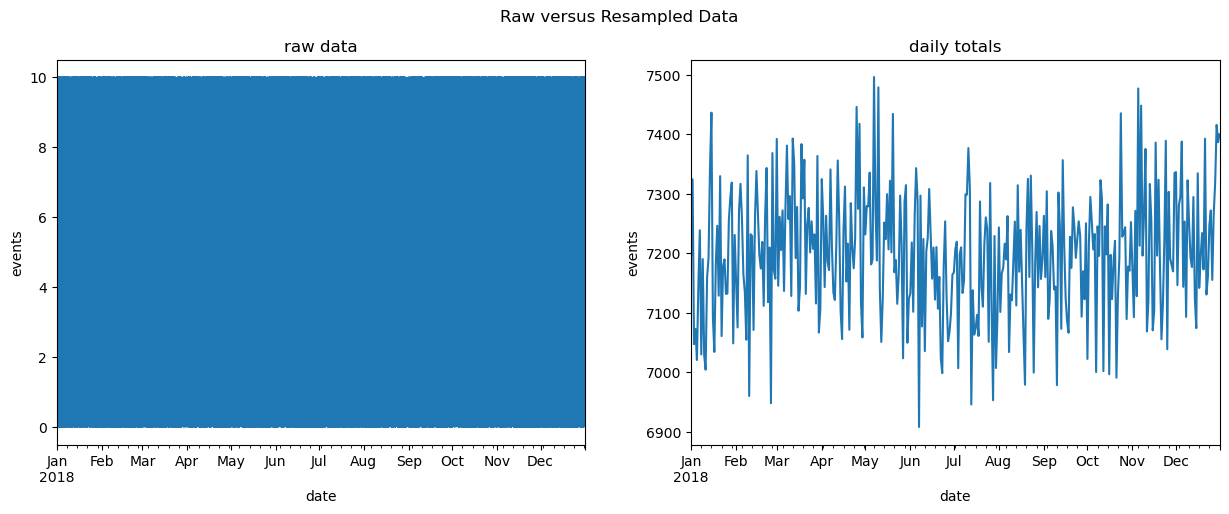

In [463]:
np.random.seed(0)
index = pd.date_range('2018-01-01', freq='min', periods=365*24*60)
raw = pd.DataFrame(np.random.uniform(0, 10, size=index.shape[0]), index=index)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

raw.plot(legend=False, ax=axes[0], title='raw data')
raw.resample('1D').sum().plot(legend=False, ax=axes[1], title='daily totals')

for ax in axes:
    ax.set_xlabel('date')
    ax.set_ylabel('events')
plt.suptitle('Raw versus Resampled Data')
plt.show()


In [464]:
stock_data_per_minute.head()

,open,high,low,close,volume
date,,,,,
2019-05-20 09:30:00,181.62,181.62,181.62,181.62,159049.00
2019-05-20 09:31:00,182.61,182.61,182.61,182.61,468017.00
2019-05-20 09:32:00,182.75,182.75,182.75,182.75,97258.00
2019-05-20 09:33:00,182.95,182.95,182.95,182.95,43961.00
2019-05-20 09:34:00,183.06,183.06,183.06,183.06,79562.00


In [469]:
stock_data_per_minute.resample('1D').agg({
                                        'open': 'first',
                                        'high': 'max',
                                        'low': 'min',
                                        'close': 'last',
                                        'volume': 'sum'
                                        })

,open,high,low,close,volume
date,,,,,
2019-05-20,181.62,184.18,181.62,182.72,10044838.00
2019-05-21,184.53,185.58,183.97,184.82,7198405.00
2019-05-22,184.81,186.56,184.01,185.32,8412433.00
2019-05-23,182.50,183.73,179.76,180.87,12479171.00
2019-05-24,182.33,183.52,181.04,181.06,7686030.00


In [477]:
stock_data_per_minute.resample('Q').mean()


C:\Users\Reuel\AppData\Local\Temp\ipykernel_204\5547097.py:1: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  stock_data_per_minute.resample('Q').mean()


,open,high,low,close,volume
date,,,,,
2019-06-30,183.45,183.45,183.45,183.45,23485.84


In [479]:
fb.drop(columns='trading_volume').resample('Q').apply(
lambda x: x.last('1D').values - x.first('1D').values
)

C:\Users\Reuel\AppData\Local\Temp\ipykernel_204\2299715798.py:1: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  fb.drop(columns='trading_volume').resample('Q').apply(
C:\Users\Reuel\AppData\Local\Temp\ipykernel_204\2299715798.py:2: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  lambda x: x.last('1D').values - x.first('1D').values
C:\Users\Reuel\AppData\Local\Temp\ipykernel_204\2299715798.py:2: FutureWarning: first is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  lambda x: x.last('1D').values - x.first('1D').values
C:\Users\Reuel\AppData\Local\Temp\ipykernel_204\2299715798.py:2: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  lambda x: x.last('1D').values - x.first('1D').values
C:\Users\Reuel\AppData\Local\Temp\

date
2018-03-31    [[-22.53, -20.160000000000025, -23.41000000000...
2018-06-30    [[39.50999999999999, 38.399700000000024, 39.84...
2018-09-30    [[-25.039999999999992, -28.659999999999997, -2...
2018-12-31    [[-28.580000000000013, -31.24000000000001, -31...
Freq: QE-DEC, dtype: object

In [483]:
melted_stock_data = pd.read_csv('melted_stock_data.csv', index_col='date', parse_dates=True)
melted_stock_data.head()


,price
date,
2019-05-20 09:30:00,181.62
2019-05-20 09:31:00,182.61
2019-05-20 09:32:00,182.75
2019-05-20 09:33:00,182.95
2019-05-20 09:34:00,183.06


In [485]:
melted_stock_data.resample('1D').ohlc()['price']

,open,high,low,close
date,,,,
2019-05-20,181.62,184.18,181.62,182.72
2019-05-21,184.53,185.58,183.97,184.82
2019-05-22,184.81,186.56,184.01,185.32
2019-05-23,182.50,183.73,179.76,180.87
2019-05-24,182.33,183.52,181.04,181.06


In [487]:
fb.resample('6H').asfreq().head()

C:\Users\Reuel\AppData\Local\Temp\ipykernel_204\2962105639.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  fb.resample('6H').asfreq().head()


,open,high,low,close,volume,trading_volume
date,,,,,,
2018-01-02 00:00:00,177.68,181.58,177.55,181.42,18151903.00,low
2018-01-02 06:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-02 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-02 18:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-03 00:00:00,181.88,184.78,181.33,184.67,16886563.00,low


In [493]:
fb.resample('6h').ffill().head()

,open,high,low,close,volume,trading_volume
date,,,,,,
2018-01-02 00:00:00,177.68,181.58,177.55,181.42,18151903,low
2018-01-02 06:00:00,177.68,181.58,177.55,181.42,18151903,low
2018-01-02 12:00:00,177.68,181.58,177.55,181.42,18151903,low
2018-01-02 18:00:00,177.68,181.58,177.55,181.42,18151903,low
2018-01-03 00:00:00,181.88,184.78,181.33,184.67,16886563,low


In [495]:
fb.resample('6H').fillna('nearest').head()

C:\Users\Reuel\AppData\Local\Temp\ipykernel_204\3498320007.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  fb.resample('6H').fillna('nearest').head()
C:\Users\Reuel\AppData\Local\Temp\ipykernel_204\3498320007.py:1: FutureWarning: DatetimeIndexResampler.fillna is deprecated and will be removed in a future version. Use obj.ffill(), obj.bfill(), or obj.nearest() instead.
  fb.resample('6H').fillna('nearest').head()


,open,high,low,close,volume,trading_volume
date,,,,,,
2018-01-02 00:00:00,177.68,181.58,177.55,181.42,18151903,low
2018-01-02 06:00:00,177.68,181.58,177.55,181.42,18151903,low
2018-01-02 12:00:00,181.88,184.78,181.33,184.67,16886563,low
2018-01-02 18:00:00,181.88,184.78,181.33,184.67,16886563,low
2018-01-03 00:00:00,181.88,184.78,181.33,184.67,16886563,low


In [497]:
fb.resample('6H').asfreq().assign(
                                volume=lambda x: x.volume.fillna(0), # put 0 when market is closed
                                close=lambda x: x.close.fillna(method='ffill'), # carry forward
                                # take the closing price if these aren't available
                                open=lambda x: np.where(x.open.isnull(), x.close, x.open),
                                high=lambda x: np.where(x.high.isnull(), x.close, x.high),
                                low=lambda x: np.where(x.low.isnull(), x.close, x.low)
                                ).head()

C:\Users\Reuel\AppData\Local\Temp\ipykernel_204\1271439007.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  fb.resample('6H').asfreq().assign(
C:\Users\Reuel\AppData\Local\Temp\ipykernel_204\1271439007.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  close=lambda x: x.close.fillna(method='ffill'), # carry forward


,open,high,low,close,volume,trading_volume
date,,,,,,
2018-01-02 00:00:00,177.68,181.58,177.55,181.42,18151903.00,low
2018-01-02 06:00:00,181.42,181.42,181.42,181.42,0.00,NaN
2018-01-02 12:00:00,181.42,181.42,181.42,181.42,0.00,NaN
2018-01-02 18:00:00,181.42,181.42,181.42,181.42,0.00,NaN
2018-01-03 00:00:00,181.88,184.78,181.33,184.67,16886563.00,low


## Merging

In [512]:
with sqlite3.connect('stocks.db') as connection:
    tables = pd.read_sql(
        "SELECT name FROM sqlite_master WHERE type='table';", connection
    )
    print(tables)
    #empty table

Empty DataFrame
Columns: [name]
Index: []


# Data Analysis

In 8.1, I learned how to collect data from a web with the use of requests library and getting the api. This is basically what we did on the earlier hands-on-activity
on web scraping using beautiful soup. The only difference is we used api key and token requests to access a dataset.

In 8.2, I did one of the Procedures in the ETL pipeline which is Transform. I transofrmed the data using merging and sorting with the use of query method.

In 8.3, I learned one of the most useful thing for visualization which is binning. It is a partitions of a data into equal parts. It is like a simplified or summary of a data if a dataset is too big for visualization on barplots, lineplot, piegraph, etc.

In 8.4, I learned aggregation which is a useful function in pivot_table, melt(), etc. This is where I learned how to do multiple computations in a single line or function. Instead of creating a function normally, agg() simplifies the work.

In 8.5, I learned how to resample the data based on time intervals. This is very important in data science because most of the datasets are time-bound and we need to analyze the data with regartds to the time.

# Supplementary Activity

### 1. With the earthquakes.csv file, select all the earthquakes in Japan with a magType of mb and a magnitude of 4.9 or greater.

In [521]:
import pandas as pd

eq = pd.read_csv('earthquakes.csv')
eq.head(5)

,mag,magType,time,place,tsunami,parsed_place
0,1.35,ml,1539475168010,"9km NE of Aguanga, CA",0,California
1,1.29,ml,1539475129610,"9km NE of Aguanga, CA",0,California
2,3.42,ml,1539475062610,"8km NE of Aguanga, CA",0,California
3,0.44,ml,1539474978070,"9km NE of Aguanga, CA",0,California
4,2.16,md,1539474716050,"10km NW of Avenal, CA",0,California


In [539]:
# use the query method to filter the data
eq.query('magType == "mb" and mag >= 4.9')

,mag,magType,time,place,tsunami,parsed_place
227,5.20,mb,1539389603790,"15km WSW of Pisco, Peru",0,Peru
229,4.90,mb,1539389546300,"193km N of Qulansiyah, Yemen",0,Yemen
248,4.90,mb,1539382925190,"151km S of Severo-Kuril'sk, Russia",0,Russia
258,5.10,mb,1539380306940,"236km NNW of Kuril'sk, Russia",0,Russia
391,5.10,mb,1539337221080,Pacific-Antarctic Ridge,0,Pacific-Antarctic Ridge
...,...,...,...,...,...,...
9154,4.90,mb,1537268270010,Southwest Indian Ridge,0,Southwest Indian Ridge
9175,5.20,mb,1537262729590,"126km N of Dili, East Timor",1,East Timor
9176,5.20,mb,1537262656830,"90km S of Raoul Island, New Zealand",0,New Zealand
9213,5.10,mb,1537255481060,South of Tonga,0,Tonga


### 2. Create bins for each full number of magnitude (for example, the first bin is 0-1, the second is 1-2, and so on) with a magType of ml and count how many are in each bin.

In [601]:
                          # insert a list of numbers for the bin to use
binned_mag = pd.cut(eq.mag, bins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])  
binned_mag.value_counts()

mag
(1, 2]     3802
(0, 1]     2941
(2, 3]     1157
(4, 5]      534
(3, 4]      233
(5, 6]      117
(6, 7]        7
(7, 8]        1
(8, 9]        0
(9, 10]       0
Name: count, dtype: int64

In [609]:
eq['binned_mag'] = binned_mag
eq.groupby('binned_mag')['magType'].count() # magType of ml and count how many are in each bin.

C:\Users\Reuel\AppData\Local\Temp\ipykernel_204\1351936696.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  eq.groupby('binned_mag')['magType'].count() # magType of ml and count how many are in each bin.


binned_mag
(0, 1]     2941
(1, 2]     3802
(2, 3]     1157
(3, 4]      233
(4, 5]      534
(5, 6]      117
(6, 7]        7
(7, 8]        1
(8, 9]        0
(9, 10]       0
Name: magType, dtype: int64

## 3. Using the faang.csv file, group by the ticker and resample to monthly frequency. Make the following aggregations:

Mean of the opening price,
<br>
Maximum of the high price,
<br>
Minimum of the low price,
<br>
Mean of the closing price,
<br>
Sum of the volume traded,

In [625]:
faang = pd.read_csv('faang.csv')
faang.head(10)

,ticker,date,open,high,low,close,volume
0,FB,2018-01-02,177.68,181.58,177.55,181.42,18151903
1,FB,2018-01-03,181.88,184.78,181.33,184.67,16886563
2,FB,2018-01-04,184.90,186.21,184.10,184.33,13880896
3,FB,2018-01-05,185.59,186.90,184.93,186.85,13574535
4,FB,2018-01-08,187.20,188.90,186.33,188.28,17994726
5,FB,2018-01-09,188.70,188.80,187.10,187.87,12393057
6,FB,2018-01-10,186.94,187.89,185.63,187.84,10529894
7,FB,2018-01-11,188.40,188.40,187.38,187.77,9588587
8,FB,2018-01-12,178.06,181.48,177.40,179.37,77551299
9,FB,2018-01-16,181.50,181.75,178.04,178.39,36183842


In [633]:
faang['date'] = faang.date.apply(pd.to_datetime) #convert to datetime the date

In [635]:
faang.set_index('date', inplace = True) #set the date to new index

In [637]:
faang

,ticker,open,high,low,close,volume
date,,,,,,
2018-01-02,FB,177.68,181.58,177.55,181.42,18151903
2018-01-03,FB,181.88,184.78,181.33,184.67,16886563
2018-01-04,FB,184.90,186.21,184.10,184.33,13880896
2018-01-05,FB,185.59,186.90,184.93,186.85,13574535
2018-01-08,FB,187.20,188.90,186.33,188.28,17994726
...,...,...,...,...,...,...
2018-12-24,GOOG,973.90,1003.54,970.11,976.22,1590328
2018-12-26,GOOG,989.01,1040.00,983.00,1039.46,2373270
2018-12-27,GOOG,1017.15,1043.89,997.00,1043.88,2109777


In [647]:
faang.groupby('ticker').resample('1ME').agg({                 #group the ticker first then resample by month then do the agg function         
                                            'open': 'mean',
                                            'high': 'max',
                                            'low': 'min',
                                            'close': 'mean',
                                            'volume': 'sum'
                                            })

open    high     low   close     volume
ticker date                                                 
AAPL   2018-01-31  170.71  176.68  161.57  170.70  659679440
       2018-02-28  164.56  177.91  147.99  164.92  927894473
       2018-03-31  172.42  180.75  162.47  171.88  713727447
       2018-04-30  167.33  176.25  158.22  167.29  666360147
       2018-05-31  182.64  187.93  162.79  183.21  620976206
       2018-06-30  186.61  192.02  178.71  186.51  527624365
       2018-07-31  188.07  193.76  181.37  188.18  393843881
       2018-08-31  210.46  227.10  195.10  211.48  700318837
       2018-09-30  220.61  227.89  213.64  220.36  678972040
       2018-10-31  219.49  231.66  204.50  219.14  789748068
       2018-11-30  190.83  220.64  169.53  190.25  961321947
       2018-12-31  164.54  184.15  145.96  163.56  898917007
AMZN   2018-01-31 1301.38 1472.58 1170.51 1309.01   96371290
       2018-02-28 1447.11 1528.70 1265.93 1442.36  137784020
       2018-03-31 1542.16 1617.54 1365.20 1540.37  130400151
       2018-04-30 1475.84 1638.10 1352.88 1468.22  129945743
       2018-05-31 1590.47 1635.00 1546.02 1594.90   71615299
       2018-06-30 1699.09 1763.10 1635.09 1698.82   85941510
       2018-07-31 1786.31 1880.05 1678.06 1784.65   97629820
       2018-08-31 1891.96 2025.57 1776.02 1897.85   96575676
       2018-09-30 1969.24 2050.50 1865.00 1966.08   94445693
       2018-10-31 1799.63 2033.19 1476.36 1782.06  183228552
       2018-11-30 1622.32 1784.00 1420.00 1625.48  139290208
       2018-12-31 1572.92 1778.34 1307.00 1559.44  154812304
FB     2018-01-31  184.36  190.66  175.80  184.96  495655736
       2018-02-28  180.72  195.32  167.18  180.27  516621991
       2018-03-31  173.45  186.10  149.02  173.49  996232472
       2018-04-30  164.16  177.10  150.51  163.81  751130388
       2018-05-31  181.91  192.72  170.23  182.93  401144183
       2018-06-30  194.97  203.55  186.43  195.27  387265765
       2018-07-31  199.33  218.62  166.56  199.97  652763259
       2018-08-31  177.60  188.30  170.27  177.49  549016789
       2018-09-30  164.23  173.89  158.87  164.38  500468912
       2018-10-31  154.87  165.88  139.03  154.19  622446235
       2018-11-30  141.76  154.13  126.85  141.64  518150415
       2018-12-31  137.53  147.19  123.02  137.16  558786249
GOOG   2018-01-31 1127.20 1186.89 1045.23 1130.77   28738485
       2018-02-28 1088.63 1174.00  992.56 1088.21   42384105
       2018-03-31 1096.11 1177.05  980.64 1091.49   45430049
       2018-04-30 1038.42 1094.16  990.37 1035.70   41773275
       2018-05-31 1064.02 1110.75 1006.29 1069.28   31849196
       2018-06-30 1136.40 1186.29 1096.01 1137.63   32103642
       2018-07-31 1183.46 1273.89 1093.80 1187.59   31953386
       2018-08-31 1226.16 1256.50 1188.24 1225.67   28820379
       2018-09-30 1176.88 1212.99 1146.91 1175.81   28863199
       2018-10-31 1116.08 1209.96  995.83 1110.94   48496167
       2018-11-30 1054.97 1095.57  996.02 1056.16   36735570
       2018-12-31 1042.62 1124.65  970.11 1037.42   40256461
NFLX   2018-01-31  231.27  286.81  195.42  232.91  238377533
       2018-02-28  270.87  297.36  236.11  271.44  184585819
       2018-03-31  312.71  333.98  275.90  312.23  263449491
       2018-04-30  309.13  338.82  271.22  307.47  262064417
       2018-05-31  329.78  356.10  305.73  331.54  142051114
       2018-06-30  384.56  423.21  352.82  384.13  244032001
       2018-07-31  380.97  419.77  328.00  381.52  305487432
       2018-08-31  345.41  376.81  310.93  346.26  213144082
       2018-09-30  363.33  383.20  335.83  362.64  170832156
       2018-10-31  340.03  386.80  271.21  335.45  363589920
       2018-11-30  290.64  332.05  250.00  290.34  257126498
       2018-12-31  266.31  298.72  231.23  265.30  234304628

## 4. Build a crosstab with the earthquake data between the tsunami column and the magType column. Rather than showing the frequency count, show the maximum magnitude that was observed for each combination. Put the magType along the columns.

In [655]:
pd.crosstab(
            index = eq.tsunami,
            columns = eq.magType,
            values = eq.mag,
            aggfunc = 'max'
            )

magType,mb,mb_lg,md,mh,ml,ms_20,mw,mwb,mwr,mww
tsunami,,,,,,,,,,
0,5.60,3.50,4.11,1.10,4.20,NaN,3.83,5.80,4.80,6.00
1,6.10,NaN,NaN,NaN,5.10,5.70,4.41,NaN,NaN,7.50


## 5. Calculate the rolling 60-day aggregations of OHLC data by ticker for the FAANG data. Use the same aggregations as exercise no. 3.

In [664]:
faang.sort_index()       # sort by the data
faang.groupby('ticker').rolling('60D').agg({                 #do the same format as exercise 3 except i changed the resample to rolling       
                                            'open': 'mean',
                                            'high': 'max',
                                            'low': 'min',
                                            'close': 'mean',
                                            'volume': 'sum'
                                            })

open   high    low  close       volume
ticker date                                               
AAPL   2018-01-02 166.93 169.03 166.04 168.99  25555934.00
       2018-01-03 168.09 171.23 166.04 168.97  55073833.00
       2018-01-04 168.48 171.23 166.04 169.23  77508430.00
       2018-01-05 168.90 172.04 166.04 169.84 101168448.00
       2018-01-08 169.32 172.27 166.04 170.08 121736214.00
...                  ...    ...    ...    ...          ...
NFLX   2018-12-24 283.51 332.05 233.68 281.93 525657894.00
       2018-12-26 281.84 332.05 231.23 280.78 520444588.00
       2018-12-27 281.07 332.05 231.23 280.16 532679805.00
       2018-12-28 279.92 332.05 231.23 279.46 521968250.00
       2018-12-31 278.43 332.05 231.23 277.45 476309676.00

[1255 rows x 5 columns]

## 6. Create a pivot table of the FAANG data that compares the stocks. Put the ticker in the rows and show the averages of the OHLC and volume traded data.

In [670]:
faang.pivot_table(index = 'ticker', aggfunc = 'mean')           # put the ticker as index then do the mean

,close,high,low,open,volume
ticker,,,,,
AAPL,186.99,188.91,185.14,187.04,34021449.63
AMZN,1641.73,1662.84,1619.84,1644.07,5649562.81
FB,171.51,173.62,169.30,171.45,27687977.67
GOOG,1113.23,1125.78,1101.00,1113.55,1742645.08
NFLX,319.29,325.22,313.19,319.62,11470299.17


## 7. Calculate the Z-scores for each numeric column of Netflix's data (ticker is NFLX) using apply().

In [688]:
#filter only the nflx ticker
nflxT = faang.query('ticker == "NFLX"')
#
nflxT.loc[:,['close', 'high', 'low', 'open', 'volume']].apply(lambda x: x.sub(x.mean()).div(x.std())).describe().T # (x - mean)/std 


,count,mean,std,min,25%,50%,75%,max
close,251.00,-0.00,1.00,-2.42,-0.71,0.04,0.76,2.04
high,251.00,0.00,1.00,-2.52,-0.71,0.04,0.77,1.99
low,251.00,-0.00,1.00,-2.41,-0.77,0.07,0.75,2.04
open,251.00,0.00,1.00,-2.50,-0.72,0.06,0.77,2.06
volume,251.00,0.00,1.00,-1.39,-0.62,-0.18,0.39,8.28


## 8. Add event descriptions:

Create a dataframe with the following three columns: ticker, date, and event. The columns should have the following values:
<br>
ticker: 'FB'
<br>
date: ['2018-07-25', '2018-03-19', '2018-03-20']
<br>
event: ['Disappointing user growth announced after close.', 'Cambridge Analytica story', 'FTC investigation']
<br>
Set the index to ['date', 'ticker']
<br>
Merge this data with the FAANG data using an outer join
<br>

In [703]:
# variables
ticker = ['FB', 'FB', 'FB']
date = ['2018-07-25', '2018-03-19', '2018-03-20']
event = ['Disappointing user growth announced after close.', 'Cambridge Analytica story', 'FTC investigation']

In [730]:
event_fng = pd.DataFrame({'ticker': ticker, 'date':date, 'event':event}) #intialize like a dict
event_fng

,ticker,date,event
0,FB,2018-07-25,Disappointing user growth announced after close.
1,FB,2018-03-19,Cambridge Analytica story
2,FB,2018-03-20,FTC investigation


In [722]:
faang = pd.read_csv('faang.csv') #get the faang.csv again
faang.head()

,ticker,date,open,high,low,close,volume
0,FB,2018-01-02,177.68,181.58,177.55,181.42,18151903
1,FB,2018-01-03,181.88,184.78,181.33,184.67,16886563
2,FB,2018-01-04,184.90,186.21,184.10,184.33,13880896
3,FB,2018-01-05,185.59,186.90,184.93,186.85,13574535
4,FB,2018-01-08,187.20,188.90,186.33,188.28,17994726


In [726]:
faang['date'] = faang.date.astype('object') # convert for merging

In [734]:
merged_fng = faang.merge(event_fng, how = 'outer', on = ['date', 'ticker'])
merged_fng.head() 

,ticker,date,open,high,low,close,volume,event
0,AAPL,2018-01-02,166.93,169.03,166.04,168.99,25555934,NaN
1,AMZN,2018-01-02,1172.00,1190.00,1170.51,1189.01,2694494,NaN
2,FB,2018-01-02,177.68,181.58,177.55,181.42,18151903,NaN
3,GOOG,2018-01-02,1048.34,1066.94,1045.23,1065.00,1237564,NaN
4,NFLX,2018-01-02,196.10,201.65,195.42,201.07,10966889,NaN


In [740]:
merged_fng.groupby('event').idxmax()          # the location of the said events

,ticker,date,open,high,low,close,volume
event,,,,,,,
Cambridge Analytica story,262,262,262,262,262,262,262
Disappointing user growth announced after close.,707,707,707,707,707,707,707
FTC investigation,267,267,267,267,267,267,267


## 9. Use the transform() method on the FAANG data to represent all the values in terms of the first date in the data.

In [742]:
transform_faang = pd.read_csv('faang.csv') # get the csv again because there is an error when adding another index
transform_faang

,ticker,date,open,high,low,close,volume
0,FB,2018-01-02,177.68,181.58,177.55,181.42,18151903
1,FB,2018-01-03,181.88,184.78,181.33,184.67,16886563
2,FB,2018-01-04,184.90,186.21,184.10,184.33,13880896
3,FB,2018-01-05,185.59,186.90,184.93,186.85,13574535
4,FB,2018-01-08,187.20,188.90,186.33,188.28,17994726
...,...,...,...,...,...,...,...
1250,GOOG,2018-12-24,973.90,1003.54,970.11,976.22,1590328
1251,GOOG,2018-12-26,989.01,1040.00,983.00,1039.46,2373270
1252,GOOG,2018-12-27,1017.15,1043.89,997.00,1043.88,2109777
1253,GOOG,2018-12-28,1049.62,1055.56,1033.10,1037.08,1413772
